# Data Preparation

Modify the data so ML algorithms can properly learn from it.

The majority of reasons why we apply some of the changes are described in the data understanding notebook. If not, we explain it here.

### Imports

In [28]:
# Import necessary libraries, functions, objects...

import pandas as pd
import numpy as np

### Load dataset

In [29]:
df = pd.read_csv('data/bank_term_deposit/bank_term_deposit.csv')
df.head()

,id,split,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,labeled,31,management,married,tertiary,no,460,no,no,cellular,28,aug,13,14,-1,0,unknown,no
1,2,labeled,34,blue-collar,married,secondary,no,1826,yes,no,unknown,20,may,203,2,-1,0,unknown,no
2,3,labeled,50,blue-collar,married,secondary,no,290,yes,no,cellular,7,aug,226,3,-1,0,unknown,no
3,4,labeled,42,admin.,divorced,secondary,no,1077,yes,no,unknown,14,may,213,1,-1,0,unknown,no
4,5,labeled,47,services,single,secondary,no,41,yes,no,cellular,5,may,298,1,-1,0,unknown,no


## Select Data

After the previous exploration you may decide to use or not use some of the data sets.

For this exercise there is **no decision to make, you use the only data set we have**.

## Clean Data

### Remove unnecessary features (if any)

### Deal with null or erroneous values (if any)

It would be nice to have a column that indicates when the `pdays` value is null (i.e., -1).

For the other columns containing 'unknown', we'll treat 'unknown' as just another valid category.

Since `pdays` and `poutcome` have their 'unknown' entries in the same rows, handling 'unknown' in `poutcome` as a special category already captures the cases where `pdays` is null. Therefore, no additional processing is needed for `pdays`.

In [30]:
# Convert ? to unknown

df.loc[df['job'] == '?', 'job'] = 'unknown'

### Deal with duplicated rows that are errors (if any)

No duplicates to remove.

### Decide what to do with outliers (if any)

Normally during this step you may decide to remove or change some outliers. However, **for this exercise do not remove any outliers**, leave them as they are.

## Construct Data

Decide if you want to create new features from the existing ones. You can be as creative as you want.

In [31]:
df.head()

,id,split,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,labeled,31,management,married,tertiary,no,460,no,no,cellular,28,aug,13,14,-1,0,unknown,no
1,2,labeled,34,blue-collar,married,secondary,no,1826,yes,no,unknown,20,may,203,2,-1,0,unknown,no
2,3,labeled,50,blue-collar,married,secondary,no,290,yes,no,cellular,7,aug,226,3,-1,0,unknown,no
3,4,labeled,42,admin.,divorced,secondary,no,1077,yes,no,unknown,14,may,213,1,-1,0,unknown,no
4,5,labeled,47,services,single,secondary,no,41,yes,no,cellular,5,may,298,1,-1,0,unknown,no


In [32]:
# Temporal

# Convert month names to numbers for easier analysis
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
             'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
df['month_num'] = df['month'].map(month_map)

# Create a season feature
def month_to_season(m):
    if m in [12, 1, 2]: return 'winter'
    elif m in [3, 4, 5]: return 'spring'
    elif m in [6, 7, 8]: return 'summer'
    return 'autumn'

df['season'] = df['month_num'].apply(month_to_season)

# Cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
df['day_sin']   = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos']   = np.cos(2 * np.pi * df['day'] / 31)

# Whether contact happened early or late in the month
df['early_month'] = (df['day'] <= 10).astype(int)
df['late_month']  = (df['day'] >= 20).astype(int)

In [33]:
# Contact

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize the three columns separately
cols = ['campaign', 'previous', 'duration']
df_norm = df.copy()
df_norm[cols] = scaler.fit_transform(df[cols])

# Normalized contact intensity: how many contacts overall (previous + current campaign + duration of last call)
df['contact_intensity'] = df_norm['campaign'] + df_norm['previous'] + df_norm['duration']

# Average time per contact during current campaign
df['avg_contact_duration'] = np.where(df['campaign'] > 0,
                                      df['duration'] / df['campaign'],
                                      0)

# Contacts per month position
df['contacts_per_month'] = df['campaign'] / df['month_num']

In [34]:
# Create a "financial stress" index using balance and loan information
df['financial_stress'] = (
    (df['balance'] < 0).astype(int)  # negative balance
    + df['loan'].map({'yes': 1, 'no': 0})
    + df['default'].map({'yes': 1, 'no': 0})
)

## Integrate Data

Decide if you want to integrate data from other sources.

**This is not needed for the exercises.**

## Feature Engineering

In [35]:
df.head()

,id,split,age,job,marital,education,default,balance,housing,loan,...,month_sin,month_cos,day_sin,day_cos,early_month,late_month,contact_intensity,avg_contact_duration,contacts_per_month,financial_stress
0,1,labeled,31,management,married,tertiary,no,460,no,no,...,-0.866025,-0.500000,-0.571268,0.820763,0,1,0.305996,0.928571,1.750,0
1,2,labeled,34,blue-collar,married,secondary,no,1826,yes,no,...,0.500000,-0.866025,-0.790776,-0.612106,0,1,0.104414,101.500000,0.400,0
2,3,labeled,50,blue-collar,married,secondary,no,290,yes,no,...,-0.866025,-0.500000,0.988468,0.151428,1,0,0.137050,75.333333,0.375,0
3,4,labeled,42,admin.,divorced,secondary,no,1077,yes,no,...,0.500000,-0.866025,0.299363,-0.954139,0,0,0.085237,213.000000,0.200,0
4,5,labeled,47,services,single,secondary,no,41,yes,no,...,0.500000,-0.866025,0.848644,0.528964,1,0,0.119902,298.000000,0.200,0


### Integer

Convert some "string boolean" columns to integer.

In [36]:
for col in ['default', 'housing', 'loan', 'y']:
    df[col] = (df[col] == 'yes').astype(int)

### Encoding

Apply the encodings that you consider more appropriate for the categorical variables.

In [37]:
# Object columns
for col in df.select_dtypes('object').columns:
    print(col)
    print(df[col].unique())
    print()

split
['labeled' 'leaderboard']

job
['management' 'blue-collar' 'admin.' 'services' 'technician' 'unemployed'
 'retired' 'unknown' 'entrepreneur' 'self-employed' 'student' 'housemaid']

marital
['married' 'divorced' 'single']

education
['tertiary' 'secondary' 'unknown' 'primary']

contact
['cellular' 'unknown' 'telephone']

month
['aug' 'may' 'jun' 'apr' 'nov' 'jan' 'feb' 'jul' 'oct' 'sep' 'mar' 'dec']

poutcome
['unknown' 'failure' 'other' 'success']

season
['summer' 'spring' 'autumn' 'winter']



#### Ordinal Encoding

Do not include `month` as we already computed `month_num`.

In [38]:
categories = {
    'education': ['unknown', 'primary', 'secondary', 'tertiary'],
}

In [39]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=list(categories.values()))
df[list(categories.keys())] = enc.fit_transform(df[list(categories.keys())])

In [40]:
# Special column for unknown education
df['education_unknown'] = (df['education'] == 0).astype(int)

#### One-hot encoding

In [41]:
fts_to_onehot = [
    'job',
    'marital',
    'contact',
    'poutcome',
    'season'
]

In [42]:
# Number of unique elements, to make sure we don't create too many columns
for ft in fts_to_onehot:
    print(ft, df[ft].nunique())

job 12
marital 3
contact 3
poutcome 4
season 4


In [43]:
df = pd.get_dummies(df, columns=fts_to_onehot, drop_first=True, dtype=int)
df.head()

,id,split,age,education,default,balance,housing,loan,day,month,...,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,season_spring,season_summer,season_winter
0,1,labeled,31,3.0,0,460,0,0,28,aug,...,1,0,0,0,0,0,1,0,1,0
1,2,labeled,34,2.0,0,1826,1,0,20,may,...,1,0,0,1,0,0,1,1,0,0
2,3,labeled,50,2.0,0,290,1,0,7,aug,...,1,0,0,0,0,0,1,0,1,0
3,4,labeled,42,2.0,0,1077,1,0,14,may,...,0,0,0,1,0,0,1,1,0,0
4,5,labeled,47,2.0,0,41,1,0,5,may,...,0,1,0,0,0,0,1,1,0,0


### Binning

Apply binning to some columns if you consider it appropriate.

In [44]:
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = range(len(age_bins) - 1)

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False).astype(int)

In [45]:
df['balance'].describe()

count     3063.000000
mean      1313.493960
std       2768.188907
min      -2076.000000
25%         58.000000
50%        394.000000
75%       1334.500000
max      42042.000000
Name: balance, dtype: float64

In [46]:
balance_bins = [-np.inf, -1000, 0, 1000, 5000, 10000, np.inf]
balance_labels = range(len(balance_bins) - 1)

df['balance_group'] = pd.cut(df['balance'], bins=balance_bins, labels=balance_labels).astype(int)

### Remove unnecessary features

In [47]:
df.drop(columns='month', inplace=True)

### All Features Are Numbers Now?

Except `split`.

In [48]:
df.select_dtypes('object')

,split
0,labeled
1,labeled
2,labeled
3,labeled
4,labeled
...,...
3058,leaderboard
3059,leaderboard
3060,leaderboard
3061,leaderboard


In [49]:
assert len(df.select_dtypes(include='number').columns) == len(df.columns) - 1

### High correlations

Decide what to do with features that are very highly correlated, if any.

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

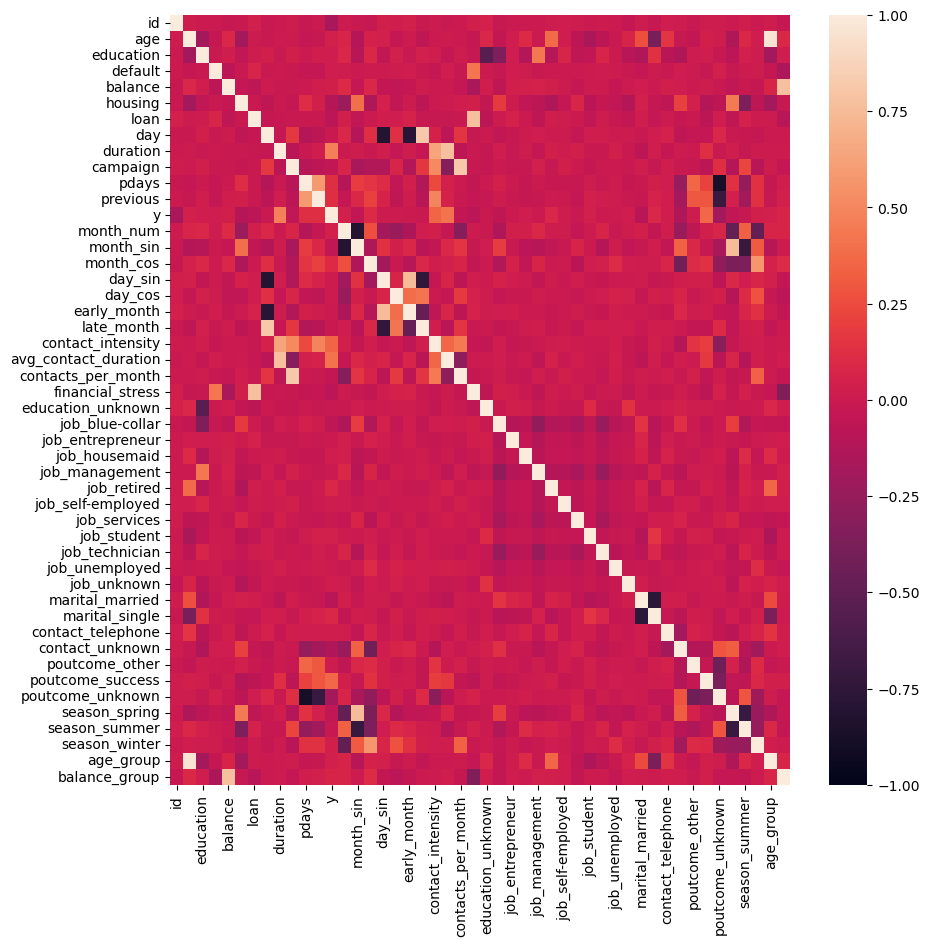

In [51]:
plt.figure(figsize=(10, 10))
corrs = df.corr(numeric_only=True)
sns.heatmap(corrs, vmin=-1, vmax=1)
plt.show()

In [52]:
# Check high correlations, ignoring same feature and only taking the diagonal

corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool)).unstack().dropna().abs().sort_values(ascending=False).head(20)

age_group             age                0.958736
poutcome_unknown      pdays              0.879116
late_month            day                0.816155
contacts_per_month    campaign           0.814205
day_sin               day                0.811444
month_sin             month_num          0.807503
early_month           day                0.784429
avg_contact_duration  duration           0.773082
balance_group         balance            0.770524
financial_stress      loan               0.768442
marital_single        marital_married    0.762146
early_month           day_sin            0.753319
season_spring         month_sin          0.751736
late_month            day_sin            0.737093
season_summer         month_sin          0.703380
                      season_spring      0.701783
poutcome_unknown      previous           0.701041
contact_intensity     duration           0.640367
previous              pdays              0.585725
season_winter         month_cos          0.564071


## Save New Dataset

In [53]:
df.to_csv('data/bank_term_deposit/bank_term_deposit_prepared.csv', index=False)